# 1. Import

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')

from path import path_dict, col_seq_cc, col_seq_elx
import data_process, data_functions, dowhy_methods
import numpy as np
import pandas as pd
from datetime import datetime
from functools import reduce
from sklearn import preprocessing
from datetime import timedelta, datetime
import seaborn as sns
import warnings
from dowhy import CausalModel
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)

/home/nneehal/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Load PMPM Data and Process


In [3]:
#### load pmpm data only
_, _, pmpm = data_process.load_data(path_dict)

### 2A. Take log of cost

In [4]:
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)
pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

In [5]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0
pmpm['MEDICAID_LOB'] = pmpm['LOB']
pmpm = pmpm.drop(['LOB'], axis=1)

In [6]:
pmpm.head()

PERS_ID     MYR  MEDICAID_LOB  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  \
0  2567954  201709             1               95      7.303     0.000   
1  2567954  201802             1               95      0.693     0.000   
2  2567954  201711             1               95      0.693     0.000   
3  2567954  201804             1               96      7.577     0.000   
4  2567954  201707             1               95      4.290     0.000   

   ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  ...  CC_PTSD  \
0     0.000    0.000         0.000              0.000  ...    0.000   
1     0.000    0.000         0.000              0.000  ...    0.000   
2     0.000    0.000         0.000              0.000  ...    0.000   
3     0.000    0.000         0.000              0.000  ...    0.000   
4     0.000    0.000         0.000              0.000  ...    0.000   

   CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  \
0             0.000                   0.000           0.000            0.000   
1             0.000                   0.000           0.000            0.000   
2             0.000                   0.000           0.000            0.000   
3             0.000                   0.000           0.000            0.000   
4             0.000                   0.000           0.000            0.000   

   CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  MBR_GNDR  
0      0.000       0.000               0.000             0.000         F  
1      0.000       0.000               0.000             0.000         F  
2      0.000       0.000               0.000             0.000         F  
3      0.000       0.000               0.000             0.000         F  
4      0.000       0.000               0.000             0.000         F  

[5 rows x 77 columns]

# 3. Training the Deep Neural Network

In [7]:
import data_generator

### 3A. Create Training Feature
col_seq_CC is the sequence of columns when using CC set of features - found in path.py in /modules

In [8]:
train_X = data_generator.generate_data(pmpm, 201701,201712, features=True, col_seq=col_seq_cc)

### 3B. Create Training Labels

In [9]:
train_Y = data_generator.generate_data(pmpm, 201701,201712, features=True, col_seq=col_seq_cc)

### 3C. Intersect two data sets

In [10]:
train_X, train_Y = data_generator.make_intersection(train_X, train_Y)

### 3D. Creating Test Feature

In [11]:
test_X = data_generator.generate_data(pmpm, 201801,201812, features=True, col_seq=col_seq_cc)

### 3E. Creating Test Labels

In [12]:
test_Y = data_generator.generate_data(pmpm, 201801,201812, features=True, col_seq=col_seq_cc)

### 3F. Intersect two data sets

In [13]:
test_X, test_Y = data_generator.make_intersection(test_X, test_Y)

In [14]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

### 3G. Define Model Architecture

In [15]:
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K
import keras_model

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [16]:
baseline_model = keras_model.make_model_6(input_shape=train_X.shape[1])

In [17]:
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4864      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
representation (Dense)       (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
__________

### 3H. Model Fit

In [18]:
num_epochs = 20

#use this when multi-dim vectored output head
baseline_history = baseline_model.fit(train_X.values, train_Y.values, epochs=num_epochs, validation_split=0.1, batch_size=128, verbose=1)

Train on 184679 samples, validate on 20520 samples
Epoch 1/20
184679/184679 [==============================] - 4s 20us/step - loss: 1.5177 - mean_absolute_error: 1.5177 - val_loss: 1.0684 - val_mean_absolute_error: 1.0684
Epoch 2/20
184679/184679 [==============================] - 3s 18us/step - loss: 1.4573 - mean_absolute_error: 1.4573 - val_loss: 1.0354 - val_mean_absolute_error: 1.0354
Epoch 3/20
184679/184679 [==============================] - 3s 18us/step - loss: 1.4215 - mean_absolute_error: 1.4215 - val_loss: 1.0096 - val_mean_absolute_error: 1.0096
Epoch 4/20
184679/184679 [==============================] - 3s 18us/step - loss: 1.3914 - mean_absolute_error: 1.3914 - val_loss: 0.9882 - val_mean_absolute_error: 0.9882
Epoch 5/20
184679/184679 [==============================] - 3s 18us/step - loss: 1.3643 - mean_absolute_error: 1.3643 - val_loss: 0.9687 - val_mean_absolute_error: 0.9687
Epoch 6/20
184679/184679 [==============================] - 3s 18us/step - loss: 1.3387 - mean

In [19]:
baseline_history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

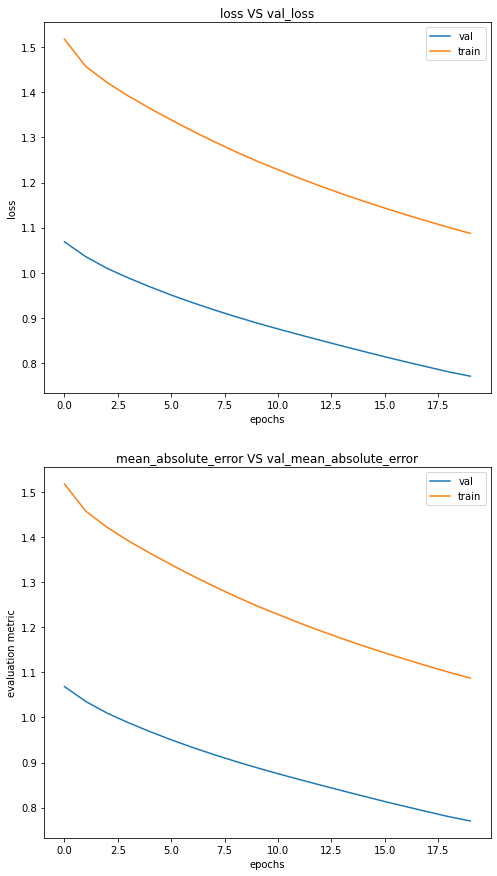

In [20]:
keras_model.plot_history(baseline_history, num_epochs, figsize=(8, 15))

In [21]:
print("Training Performance:",baseline_model.evaluate(train_X.values, train_Y.values))
print("Test Performance:",baseline_model.evaluate(test_X.values, test_Y.values))

205199/205199 [==============================] - 3s 13us/step
Training Performance: [1.0497698620710358, 1.0497698620710358]
212510/212510 [==============================] - 3s 13us/step
Test Performance: [1.05777884879778, 1.05777884879778]


### 3I. Latent Model upto Representation Layer

In [22]:
latent_model = tf.keras.Model(baseline_model.input, baseline_model.get_layer("representation").output)

In [23]:
latent_model.predict(train_X).shape

In [24]:
#freeze all the layers in both models
for layer in baseline_model.layers:
    layer.trainable=False
for layer in latent_model.layers:
    layer.trainable=False

### 3J. Save the Model

In [25]:
## save the models
baseline_model.save('../temp/TF_Full_Model_m6b')
latent_model.save('../temp/TF_Latent_Model_m6b')

In [26]:
#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Latent_Model_m6b',
                bucket, 
                'rpi/nneehal/MODELS/TF_Latent_Model_m6b',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Full_Model_m6b',
                bucket, 
                'rpi/nneehal/MODELS/TF_Full_Model_m6b',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})